# Predicting Industry and Job Roles from Job Descriptions: A Multi-Task Learning Perspective

Learning Team 3
- Francis Mark Cayco
- Marianne Reyes
- Imee Lanie Uy
- Denver Valera

**COSCI 221 - Machine Learning 1** <br>
Master of Science in Data Science 2025

## Introduction
Many prediction tasks demand multiple outputs, not just a single label. Multi-output learning, a subset of supervised learning, is designed to handle these scenarios. Unlike traditional classification, multi-output models can predict multiple interdependent labels simultaneously.
Multi-output learning can be categorized based on the number and nature of target variables, as illustrated in the table below:

| Classification Type | Number of targets | Target cardinality | Valid `type_of_target` |
|---|---|---|---|
| Multiclass classification | 1 | >2 | `'multiclass'` |
| Multilabel classification | >1 | 2 (0 or 1) | `'multilabel-indicator'` |
| Multiclass-multioutput classification | >1 | >2 | `'multiclass-multioutput'` |
| Multioutput regression | >1 | Continuous | `'continuous-multioutput'` |

*Table 1: Types of Multiclass and Multioutput Tasks*

### Problem Statement
Job platforms often provide job descriptions along with specific identifiers like industry and employment status (e.g., full-time, part-time, contractual). The study aims to address the question: Can these identifiers be accurately predicted solely from the job description?

The study will utilize the Job Description dataset from Kaggle. The primary objective is to build a model capable of predicting the correct industry and employment status based solely on the provided job description.

**Multioutput Classification**

To address this multi-output prediction problem, the group will employ a Multi-Output Classification approach as it involves >1 targets and >2 target cardinality. The job descriptions will serve as input features, while the target variables will be the job type and category. By training a multi-output model, the group aims to accurately classify job listings based on their textual content.

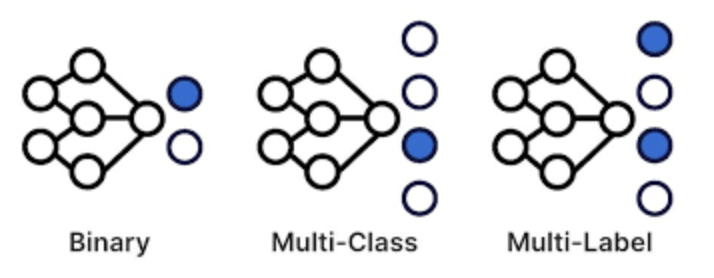

### Highlights 

1. Complexity 

Multi-output learning models offer a generalized approach to simultaneously predicting multiple target variables. However, interpreting these models can be complex due to the intricate interplay between multiple outputs. As the number of target variables and their interdependencies increase, the model must learn increasingly complex relationships. To effectively capture these relationships and enhance performance, a substantial amount of data is often required. Larger datasets enable the model to identify subtle patterns and correlations. 

Additionally, assessing the independence of target variables is crucial. Multi-output models generally perform better when the targets are interdependent. The ClassifierChain, a multi-output algorithm that sequentially trains binary classifiers, leverages these interdependencies. Each classifier's prediction serves as an input for the next, enabling the model to capture complex relationships and improve overall predictive accuracy. 

 

2. Error Propagation 

Multioutput algorithms are susceptible to errors due to their simultaneous prediction of multiple target variables. An error in one output can diminish the overall accuracy, particularly when outputs have varying importance. Imbalances in a specific target variable can further exacerbate this issue. This is especially pronounced when target variables are interdependent. For instance, misclassifying a job type while correctly identifying the industry category can lead to practical challenges for both employers and job seekers, as these outputs are often used in tandem for decision-making. 

 

3. Evaluation Metrics 

The multiclass multioutput scikit-learn library does not have a built-in scoring metric. This necessitates the creation of custom evaluation metrics to assess the model's performance. One approach is to calculate accuracy for each target variable individually and then combine these scores into a weighted average. Alternatively, comparing the performance of a multi-output model against separate single-output models can provide insights into the trade-offs between complexity and performance. However, it's important to consider the computational cost and training time associated with multi-output models. A more complex model may require significant computational resources and longer training times. Therefore, it's crucial to balance model complexity with practical considerations like computational efficiency and deployment time. 

In [101]:
%pip install -r requirements.txt

  Cloning https://github.com/phiyodr/multilabel-oversampling to /private/var/folders/94/qqxkptrd1bg66t_3104htv1m0000gn/T/pip-req-build-egew7015
  Running command git clone --filter=blob:none --quiet https://github.com/phiyodr/multilabel-oversampling /private/var/folders/94/qqxkptrd1bg66t_3104htv1m0000gn/T/pip-req-build-egew7015
  Resolved https://github.com/phiyodr/multilabel-oversampling to commit 5fa066171b8df7ef369fe4f0c674f9576a106b0e
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import multiprocessing as mp
import re

import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from scipy.stats import chi2_contingency
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, ShuffleSplit, cross_validate,
                                     train_test_split)
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from tqdm import tqdm

from utils import translate

nltk.download(['punkt_tab','wordnet'])

RANDOM_STATE = 420
np.random.seed(RANDOM_STATE)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/francismarkcayco/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/francismarkcayco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<div class="alert alert-info">

## Exploratory Data Analysis
</div>

In [11]:
df = pd.read_csv('dataset.csv')
df.head(5)

,job_no,job_description,job_type,category
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
4,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations


/var/folders/94/qqxkptrd1bg66t_3104htv1m0000gn/T/ipykernel_19226/3816780819.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(title='% Occurence', bbox_to_anchor=(1.05, 1), loc='best')


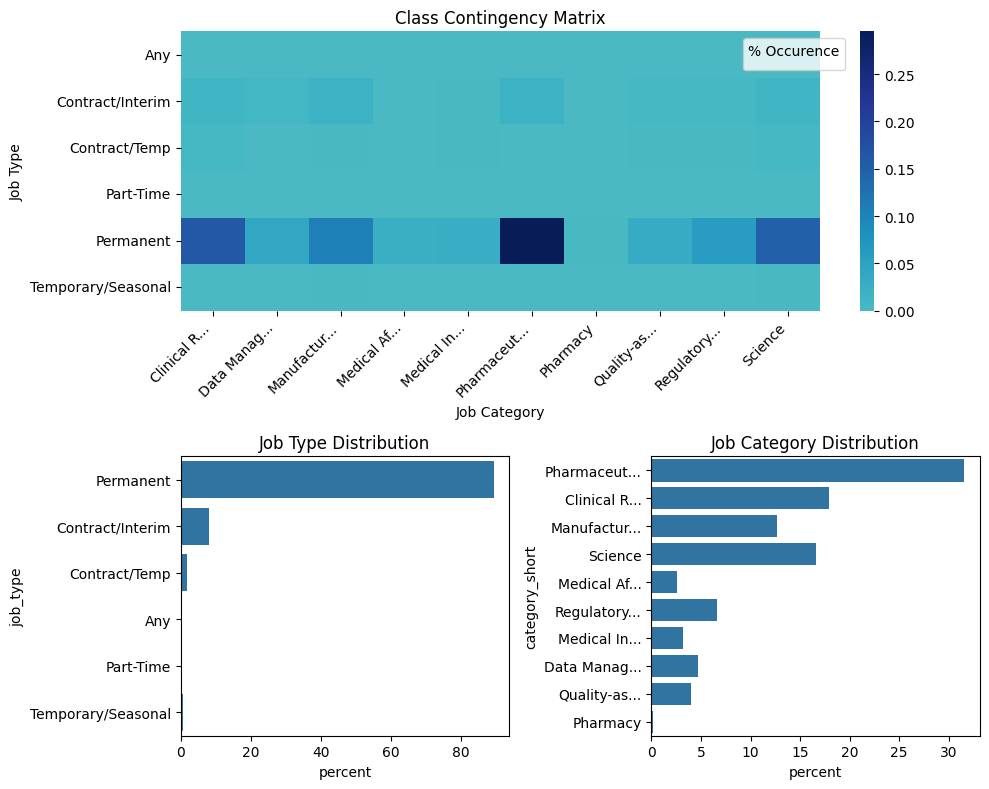

In [12]:
df['category_short'] = df['category'].apply(lambda x: x[:10] + '...' if len(x) > 10 else x)
label_counts = pd.crosstab(df['job_type'], df['category_short'],normalize='all')
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, :])
sns.heatmap(label_counts, cmap='YlGnBu', ax=ax1, cbar=True, linecolor='black', center=0.01)
ax1.set_ylabel('Job Type')
ax1.set_xlabel('Job Category')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Class Contingency Matrix')
ax1.legend(title='% Occurence', bbox_to_anchor=(1.05, 1), loc='best')

ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title('Job Type Distribution')
sns.countplot(df['job_type'], ax=ax2, stat='percent')

ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title('Job Category Distribution')
sns.countplot(df['category_short'], ax=ax3, stat='percent')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

The data appears to be imbalanced in several ways. Firstly, the distribution of job types is skewed towards "Permanent" roles, with other types like "Part-Time" and "Temporary/Seasonal" being significantly underrepresented. This suggests that the dataset may not accurately reflect the full spectrum of job types in the relevant job market. Secondly, certain job categories, such as "Pharmaceuticals" and "Clinical Research," are more prevalent than others, indicating a potential bias towards specific industries or sectors. This imbalance could lead to a model that is less accurate in predicting less common job types or categories.

In [13]:
job_type_distribution = df['job_type'].value_counts().reset_index()
job_type_distribution['percentage'] = job_type_distribution['count'] / job_type_distribution['count'].sum()
job_type_pcc = np.sum(job_type_distribution['percentage']**2)

print(f"PCC of Job Type Distribution: {job_type_pcc:.2f}")

category_distribution = df['category_short'].value_counts().reset_index()
category_distribution['percentage'] = category_distribution['count'] / category_distribution['count'].sum()
category_pcc = np.sum(category_distribution['percentage']**2)
print(f"PCC of Job Category Distribution: {category_pcc:.2f}")

print("Overall PCC: {:.2f}".format((job_type_pcc + category_pcc) / 2))

PCC of Job Type Distribution: 0.81
PCC of Job Category Distribution: 0.19
Overall PCC: 0.50


High PCC for job type indicates a significant imbalance in the distribution of job types.  A high PCC means one or a few classes (in this case, job types like "Permanent") dominate the dataset.

Meanwhile, the low PCC for job category suggests a more balanced distribution across job categories. While less imbalanced than job type, certain categories like "Pharmaceuticals" and "Clinical Research" were still more frequent than others.

### Assumption of Label Independence

In multiclass, multioutput classification, the assumption of dependence on a multioutput class means that the multiple output labels are **not independent** of each other. They are somehow related or correlated, and predicting them together, considering their dependencies, can lead to better performance than predicting each independently.

The test also determines if we can either (1) train each label independently or (2) train them together. If the labels are dependent, training them together is more beneficial.


In order to test if the two labels are dependent, we can use the Chi-Square test of independence. The Chi-Square test of independence is a statistical test used to determine whether there is a significant association between two categorical variables. In this case, we can use it to determine if the job type and job category are dependent on each other.



In [14]:
stat, p, _, _ = chi2_contingency(label_counts)
print(f'Chi-Square Statistic: {stat:.3f}')
print(f'P-value: {p:.3f}')

Chi-Square Statistic: 0.034
P-value: 1.000


Assuming that our significance value is 0.05 and the p-value is 1.0, we fail to reject the null hypothesis. This means that the two labels are independent of each other. There is no statistically significant association between the two categorical variables represented.

Even if there is no statistically significant relationship between the two, the analysis will involve training the labels together, and training them independently will be considered as a baseline model.  ***We will see if the test dataset will have a better performance when the labels are trained together compared to when they are trained independently.***

<div class="alert alert-info">

## Preprocessing and Feature Extraction
</div>

There are four columns: `job_no`, `job_description`, `job_type`, and `category`.  The last two columns are the labels while the `job_decription` is the feature.  Upon inspecting the contents of the `job_description`, some rows are not in English.  Instead of deleting them, we opted to translate the contents into English.

In [15]:
df['lang'] = df['job_description'].apply(detect)

### Text Translation

`landetect` is a language detection library ported from Java.  It has the following features:
- Generate language profiles from Wikipedia abstract xml
- Detect language of a text using naive Bayesian filter
- 99% over precision for 53 languages

The language detection algorithm is non-deterministic, but it is consistent in the sense that the same text will always return the same language.

Source: https://github.com/shuyo/language-detection/blob/wiki/ProjectHome.md

In [16]:
df['lang'].value_counts(normalize=True)*100

lang
en    69.983576
es     9.973382
fr     9.922410
de     9.877103
it     0.215212
sv     0.028317
Name: proportion, dtype: float64

70% of the `job_description`s are written in English.  The rest are written in Español, Français, and Deutsch, Italiano, and Swedish.  

To translate the non-English `job_description`s, we used `libretranslate`, a free and open-source machine translation service.  The self-hosted version of `libretranslate` is used in this project.  To install the API server, follow the instructions in the [libretranslate repository](https://github.com/LibreTranslate/LibreTranslate?tab=readme-ov-file#install-and-run).

In your CLI, run the following command:

`libretranslate --load-only de,it,sv,en,es,fr --update-models --debug`

Create a request to the localhost translation API.  Note that due to `multiprocessing` library limitations, the method is imported instead of being defined in the notebook.
```
def translate(args):
    text, source = args
    url = "http://127.0.0.1:5000/translate"
    body = {
        "q": text,
        "source": source,
        "target": "en",
        "format": "text",
    }
    response = requests.post(url, json=body)

    if response.status_code != 200:
        raise Exception(response.json())

    return response.json()["translatedText"]
```

<div class="alert alert-warning">

### Performance Warning

The translation process is time-consuming.  It took ~10 hours to translate 5301 rows of non-English `job_description`s.  This could take a lot longer when ran in Jojie or Google Colab.

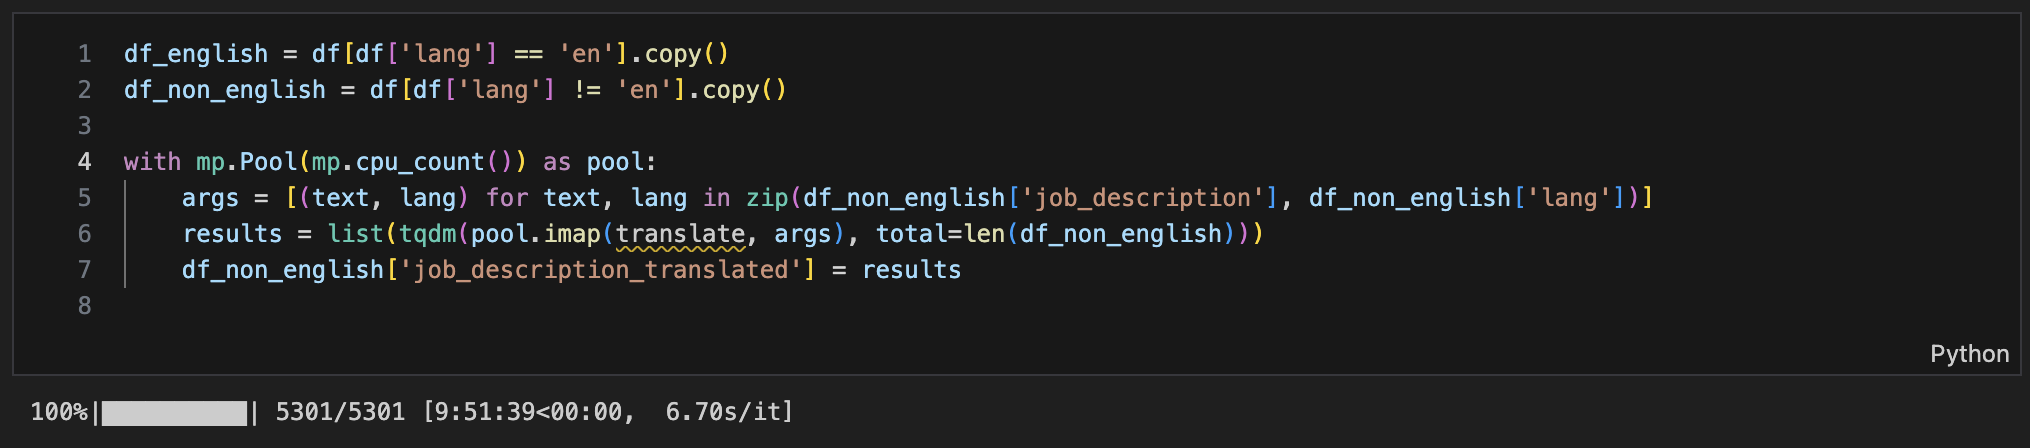

Skip this step if you have already translated the non-English `job_description`s and proceed to the cell reading the `dataset_translated.csv` file.
</div>


In [ ]:
df_english = df[df['lang'] == 'en'].copy()
df_non_english = df[df['lang'] != 'en'].copy()

with mp.Pool(mp.cpu_count()) as pool:
    args = [(text, lang) for text, lang in zip(df_non_english['job_description'], df_non_english['lang'])]
    results = list(tqdm(pool.imap(translate, args), total=len(df_non_english)))
    df_non_english['job_description_translated'] = results


100%|██████████| 5301/5301 [9:51:39<00:00,  6.70s/it]     


In [ ]:
df_english['job_description_translated'] = df_english['job_description']
df = pd.concat([df_english, df_non_english])
df.to_csv('dataset_translated.csv', index=False)

Read the translated dataset.

In [3]:
df = pd.read_csv('dataset_translated.csv')
df.head(5)

,job_no,job_description,job_type,category,lang,job_description_translated
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en,Zest Scientific is searching for an accomplis...
1,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing,en,Asha Mistry of Umbilical Life is recruiting an...
2,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en,Sales Representative - Laser in der Medizinte...
3,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations,en,Field Service Engineer - Life Science\r\r\r\nC...
4,Id-16692,Due to increased business demand this award w...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en,Due to increased business demand this award w...


In [4]:
df_unique = df[['job_type','category','lang','job_description_translated']].drop_duplicates()

print(f"Number of unique job descriptions: {len(df_unique)}")

Number of unique job descriptions: 9444


### Tokenization

For the tokenization process, we used the `nltk` library and some RegEx:
- Remove special characters
- Remove numbers
- Remove characters of length 1 and 2.
- Word tokenizes using nltk's `word_tokenize` function.
- Lemmatize the words using nltk's `WordNetLemmatizer`.
- Translates British English to American English.

In [5]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

        url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/american_spellings.json"
        self.american_british_dict = requests.get(url).json()

    def __call__(self, doc):
        doc = re.sub(r'\W+', ' ', doc)
        doc = re.sub(r'\b\w{1,2}\b', '', doc)
        doc = re.sub(r'\d+', '', doc)

        words = []
        for t in word_tokenize(doc):
            word = self.wnl.lemmatize(t)
            word = self.american_british_dict.get(word, word)
            words.append(word)
        return words

### Feature Extraction
We used the `TfidfVectorizer` to convert the `job_description` into a matrix of TF-IDF features.

In [6]:
vectorizer = TfidfVectorizer(
    tokenizer=LemmaTokenizer(),
    stop_words='english',
    strip_accents = 'unicode',
    )
X = vectorizer.fit_transform(df_unique['job_description_translated'])
print("Shape: ", X.shape)
print("Sample features: ", vectorizer.get_feature_names_out()[10:])

/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


Shape:  (9444, 13324)
Sample features:  ['ab' 'abandon' 'abandonment' ... 'zurich' 'zweck' 'zwingend']


### Dimensionality Reduction

Since we have `13324` features and `9444` samples, we used the `TruncatedSVD` to reduce the dimensionality of the dataset to $N$ features.

Why `TruncatedSVD`?
- Does not require the input data to be mean-centered.
- It is faster than PCA  
- Works with sparse matrices which commonly occurs in TF-IDF matrices.

See how much variance is explained by the first `4000` components

In [7]:
svd = TruncatedSVD(4000)
X_svd = svd.fit_transform(X)

# of components to explain 70.0% of variance: 715
# of components to explain 75.0% of variance: 929
# of components to explain 80.0% of variance: 1242
# of components to explain 85.0% of variance: 1768
# of components to explain 88.0% of variance: 2359
# of components to explain 90.0% of variance: 3153


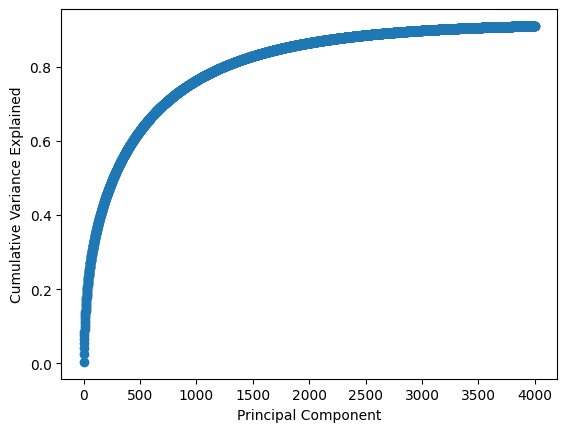

In [8]:
variance_explained = svd.explained_variance_.cumsum()
plt.plot(range(1, len(variance_explained)+1), variance_explained, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')

for variance in [0.7,0.75, 0.8, 0.85, 0.88,0.9]:
    print(f"# of components to explain {variance*100}% of variance: {np.argwhere(variance_explained > variance)[0][0]}")

For this project, we used the first `1768` components as it already explains 85% of the variance.

In [9]:
X_svd = X_svd[:, :np.argwhere(variance_explained > 0.85)[0][0]]
X_svd.shape

(9444, 1768)

### Label Encoding

Transform the categorical labels to numerical values using `LabelEncoder`.

In [10]:
job_type_encoder = LabelEncoder()
category_encoder = LabelEncoder()

df_unique['job_type'] = job_type_encoder.fit_transform(df_unique['job_type'])
df_unique['category'] = category_encoder.fit_transform(df_unique['category'])

y = df_unique[['job_type','category']]
df_unique

,job_type,category,lang,job_description_translated
0,4,6,en,Zest Scientific is searching for an accomplis...
1,1,5,en,Asha Mistry of Umbilical Life is recruiting an...
2,4,6,en,Sales Representative - Laser in der Medizinte...
3,4,2,en,Field Service Engineer - Life Science\r\r\r\nC...
4,4,6,en,Due to increased business demand this award w...
...,...,...,...,...
17650,4,10,es,Veterinary pathologist with scientific respons...
17651,4,9,fr,Experienced medical writing - Germany - Advice...
17652,4,2,fr,QMS specialists - German Switzerland - growing...
17653,4,2,de,"Alcon, United Kingdom\nWould you like to work ..."


<div class="alert alert-info">

## Part 1: Model Training - Independent Labels

`sklearn.multioutput.MultiOutputClassifier` is a type of machine learning model that can predict multiple target variables simultaneously for a given input.  Instead of predicting just one output, like in traditional classification, it predicts two or more outputs.  In this type, we treat each output independently and assumes that they are not related to each other.

The following models already upport multi-class multi-output classification so they do not require to be wrapped inside `MultiOutputClassifier`:
- **DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier, and GradientBoostingClassifier**
  
  At each node, decision trees find the best split based on all output labels simultaneously. They can naturally predict multiple outputs at leaf nodes. This extends to ensembles like Random Forests and Gradient Boosting.
  
- **KNeighborsClassifier and RadiusNeighborsClassifier**
  
  KNN directly uses the labels of the k nearest neighbors to predict multiple outputs. It doesn't have a separate training phase, so it can readily adapt to multiple output labels.
  
Meanwhile, some models that do not support multi-class multi-output classification has to be wrapped inside `MultiOutputClassifier`.  Examples include:
- **LogisticRegression and Support Vector Machines**
  
  These models are traditionally designed for single-output problems. They optimize a single decision boundary or set of weights for one output.

- **Naive Bayes**
  
  Built on the "naive" assumption that features are conditionally independent given the class label. This means it calculates the probability of each feature occurring independently of other features, given a specific class.

We wil compare the results between labels trained independently and labels trained together.
</div>

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X_svd, y, test_size=0.25)
# Validation set is already included in the training set

### Upsampling the Minority Classes

Since the dataset is imbalanced, we upsampled the minority classes using the custom oversampling technique.  Many algorithms for imbalanced data support binary and multiclass classification only, so we had to find a custom oversampling technique for multi-label classification.

The following is the custom oversampling technique implemented in this [GitHub repository](https://github.com/phiyodr/multilabel-oversampling):
- Calculate counts per class and then calculate the standard deviation of the count values
- Do for `number_of_adds` times the following:
    - Randomly draw a sample from your data and calculate new std
    - If new std reduces, add sample to your dataset
    - If not, draw another sample (to this up to `number_of_tries` times)
- A new DataFrame is returned.

**Note: We're decided to remove the oversampling part as all models have overfitted the data.  To see the results when oversampling is implemented, uncomment the code below.**

In [12]:
# import multilabel_oversampling as mo
# train = pd.DataFrame(x_train).merge(y_train, left_index=True, right_index=True)

# upsampler = mo.MultilabelOversampler(number_of_adds=10000)
# sampled_train = upsampler.fit(train, target_list=['job_type','category'])

# x_train = sampled_train.drop(columns=['job_type','category'])
# y_train = sampled_train[['job_type','category']]

# upsampler.plot_index_counts()

### Define a custom scoring function
Sklearn [does not have a native metric](https://scikit-learn.org/1.5/modules/multiclass.html#multiclass-multioutput-classification)  to support multiclass multioutput classification .  We created a custom scoring function that computes the F1 score for each class and averages them.

In [13]:
def f1_multiclass_multioutput(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean([f1_score(y_true[:, i], y_pred[:, i], average='micro') for i in range(y_true.shape[1])])

### Model Selection

For hyperparameter tuning, we used the `GridSearchCV` with the custom scoring function and `n_iter` of 100.

For the cross-validation, we used the `ShuffleSplit` (equivalent to Monte-Carlo CV) with `n_splits=5`.  We used the following models:

In [89]:
cv = ShuffleSplit(n_splits=5, test_size=0.25) # test size equal to the validation set
param_grid = [
    {
        "clf": [DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreeClassifier(), ExtraTreesClassifier()],
        'clf__max_depth': [10, 20, 30],
        'clf__min_samples_split': [2, 10, 100],
    },
    {
        "clf": [KNeighborsClassifier()],
        'clf__n_neighbors': [5, 10, 100],
        'clf__weights': ['uniform', 'distance'],
    },
    {
        "clf": [MultiOutputClassifier(LogisticRegression(max_iter=10000, penalty='l2')), 
                MultiOutputClassifier(LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear'))],
        "clf__estimator__C": [0.01, 0.05, 0.1, 0.05,1, 1.5, 2, 2.5, 3],
    },
    {
        "clf": [RadiusNeighborsClassifier()],
        'clf__radius': [1,5,10,15],
        'clf__weights': ['uniform', 'distance'],
    },
    # Removed SVC due to long training times
    # { #
    #     "clf": [MultiOutputClassifier(SVC())],
    #     "clf__estimator__C": [0.01, 0.1, 1.4, 10],
    # }
]

steps = [('clf', None)]
pipe = Pipeline(steps)
clf = RandomizedSearchCV(pipe,
                         param_distributions=param_grid,
                         n_iter=100,
                         cv=cv,
                         n_jobs=-1,
                         scoring=make_scorer(f1_multiclass_multioutput),
                         verbose=2) # ,
clf.fit(x_train, y_train)

/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 68 is smaller than n_iter=100. Running 68 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 68 candidates, totalling 340 fits
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=10; total time=  10.2s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=10; total time=  10.2s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=2; total time=  10.4s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=2; total time=  10.4s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=2; total time=  10.4s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=2; total time=  10.4s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=10; total time=  10.5s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=2; total time=  10.8s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=100; total time=   9.9s
[CV] E

/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=uniform; total time=   0.9s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=uniform; total time=   0.8s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=uniform; total time=   0.7s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=uniform; total time=   0.4s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=uniform; total time=   0.5s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=distance; total time=   0.5s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=distance; total time=   0.5s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=distance; total time=   0.5s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=distance; total time=   0.5s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=distance; total time=   0.8s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=uniform; total time=   1.8s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=uniform; total time=   1.5s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=uniform; total time=   1.0s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000, penalty='l1',
                                                   solver='liblinear')), clf__estimator__C=2.5; total time= 1.1min
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=uniform; total time=   1.2s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000, penalty='l1',
                                                   solver='liblinear')), clf__estimator__C=2.5; total time= 1.1min
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=distance; total time=   1.6s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=distance; total time=   1.6s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=distance; total time=   1.9s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=distance; total time=   2.0s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=uniform; total tim

/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.66691135 0.66713721 0.66979108 0.62811971 0.6282891  0.65375494
 0.62501412 0.62721626 0.65296443 0.63636364 0.63862225 0.63873518
 0.65866742 0.65341615 0.64607566 0.66188594 0.65595709 0.64793902
 0.57137211 0.57611519 0.56629023 0.59480519 0.60231508 0.58322981
 0.57436477 0.58153586 0.58029362 0.60519481 0.60643704 0.59661208
 0.64664032 0.64635799 0.62817617 0.65793337 0.65127047 0.63162055
 0.70485601 0.68706945 0.70169396 0.68740824 0.68735178 0.67029927
 0.60734049 0.64760023 0.6622812  0.64760023 0.71637493 0.71948052
 0.71846414 0.71795596 0.71795596 0.60779221 0.64263128 0.66075663
 0.64263128 0.71473744 0.71897233 0.72049689 0.72168267 0.71953698
        nan        nan 0.55194805 0.57391304 0.55194805 0.57391304
 0.55194805 0.57391304]
  warnings.warn(


RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.25, train_size=None),
                   estimator=Pipeline(steps=[('clf', None)]), n_iter=100,
                   n_jobs=-1,
                   param_distributions=[{'clf': [DecisionTreeClassifier(),
                                                 RandomForestClassifier(),
                                                 ExtraTreeClassifier(),
                                                 ExtraTreesClassifier()],
                                         'clf__max_depth': [10, 20, 30],
                                         'clf__min_samples_split': [2, 10,
                                                                    100]},
                                        {'...
                                        {'clf': [MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000)),
                                                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000,
                                                                                                    penalty='l1',
                                                                                                    solver='liblinear'))],
                                         'clf__estimator__C': [0.01, 0.05, 0.1,
                                                               0.05, 1, 1.5, 2,
                                                               2.5, 3]},
                                        {'clf': [RadiusNeighborsClassifier()],
                                         'clf__radius': [1, 5, 10, 15],
                                         'clf__weights': ['uniform',
                                                          'distance']}],
                   scoring=make_scorer(f1_multiclass_multioutput, response_method='predict'),
                   verbose=2)

Let's see the results of the models.

In [90]:
output = clf.predict(x_test)

# Translate the output back to the original categories
output = pd.DataFrame(output, columns=['job_type','category'])
output['job_type'] = job_type_encoder.inverse_transform(output['job_type'])
output['category'] = category_encoder.inverse_transform(output['category'])
output

,job_type,category
0,Permanent,Clinical Research
1,Permanent,Clinical Research
2,Contract/Interim,Manufacturing & Operations
3,Permanent,Science
4,Permanent,Quality-assurance
...,...,...
2356,Permanent,Medical Information and Pharmacovigilance
2357,Contract/Interim,Science
2358,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
2359,Permanent,Manufacturing & Operations


### Model Evaluation

In [91]:
results = pd.DataFrame(clf.cv_results_)
results = results.sort_values(by='rank_test_score')
results[['rank_test_score','param_clf','mean_test_score','mean_fit_time','mean_score_time','params']].head(5)

,rank_test_score,param_clf,mean_test_score,mean_fit_time,mean_score_time,params
58,1,MultiOutputClassifier(estimator=LogisticRegres...,0.721683,61.739737,0.069402,"{'clf__estimator__C': 2.5, 'clf': MultiOutputC..."
57,2,MultiOutputClassifier(estimator=LogisticRegres...,0.720497,50.851111,0.066720,"{'clf__estimator__C': 2, 'clf': MultiOutputCla..."
59,3,MultiOutputClassifier(estimator=LogisticRegres...,0.719537,68.121029,0.045109,"{'clf__estimator__C': 3, 'clf': MultiOutputCla..."
47,4,MultiOutputClassifier(estimator=LogisticRegres...,0.719481,10.239916,0.039733,"{'clf__estimator__C': 1.5, 'clf': MultiOutputC..."
56,5,MultiOutputClassifier(estimator=LogisticRegres...,0.718972,36.375717,0.059266,"{'clf__estimator__C': 1.5, 'clf': MultiOutputC..."


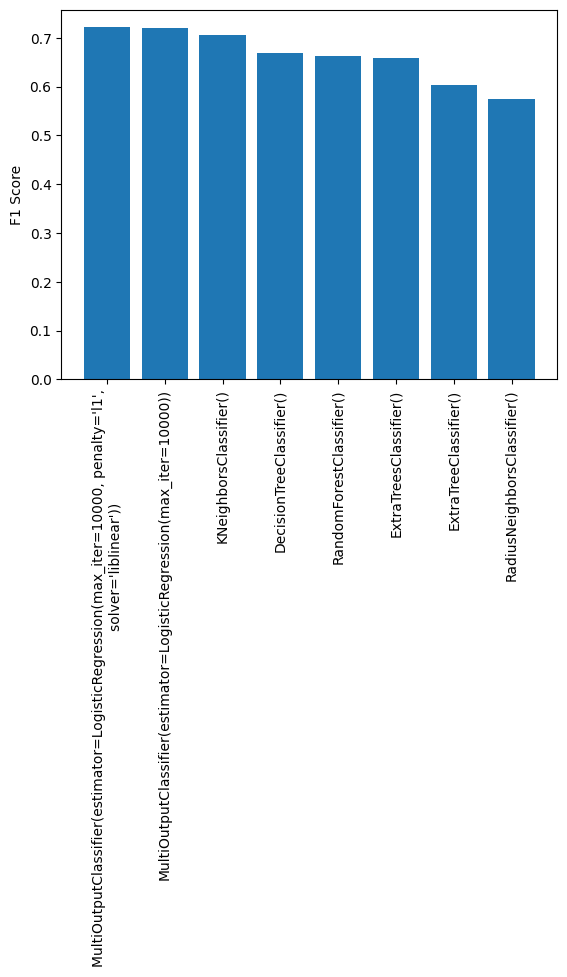

In [92]:
results["param_clf_str"] = results["param_clf"].astype(str)
idx = results.groupby("param_clf_str")["mean_test_score"].idxmax()
max_results = results.loc[idx, ["param_clf_str","mean_test_score", "rank_test_score", "params"]].sort_values("mean_test_score", ascending=False)

plt.bar(max_results["param_clf_str"], max_results["mean_test_score"])
plt.ylabel("F1 Score")
plt.xticks(rotation=90)
plt.show()

In [93]:
score = clf.score(x_test, y_test)
print(clf.best_estimator_)
print("Best model's score on the test dataset: ", score)

Pipeline(steps=[('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(C=2.5,
                                                                    max_iter=10000,
                                                                    penalty='l1',
                                                                    solver='liblinear')))])
Best model's score on the test dataset:  0.717704362558238


### Sensitivity Analysis on Logistic Regression

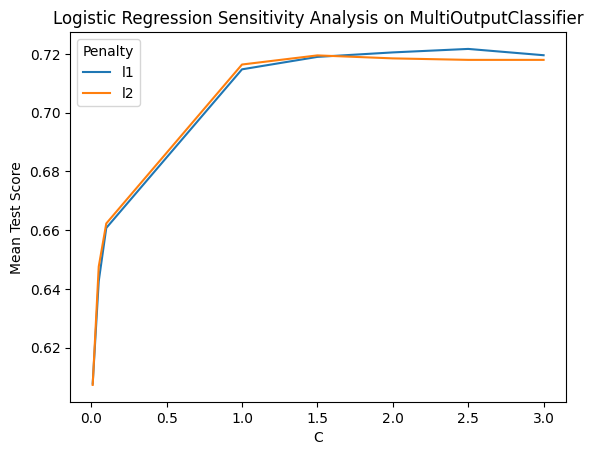

In [94]:
logreg_results = results[results['param_clf_str'].str.contains('LogisticRegression')].sort_values(by='param_clf__estimator__C')

fig, ax = plt.subplots()

l1_penalty_results = logreg_results[logreg_results['param_clf_str'].str.contains('l1')]
ax.plot(l1_penalty_results['param_clf__estimator__C'], l1_penalty_results['mean_test_score'], label='l1')

l2_penalty_results = logreg_results[~logreg_results['param_clf_str'].str.contains('l1')]
ax.plot(l2_penalty_results['param_clf__estimator__C'], l2_penalty_results['mean_test_score'], label='l2')

ax.set_xlabel('C')
ax.set_ylabel('Mean Test Score')
ax.legend(title='Penalty')
ax.set_title('Logistic Regression Sensitivity Analysis on MultiOutputClassifier')
plt.show()

The plot clearly shows that regularization (controlled by C) has a significant impact on the model's performance as measured by mean test score.   For both L1 and L2 penalties, the model's performance generally improves as C increases from very small values (around 0.0) to around 1.0. After this point, the improvements become less pronounced an has the potential to overfit.  It is also worth noting that higher `C` values tend to be less efficient.

### What happens when we train each label separately?


In [95]:
multioutput_clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5))
multioutput_clf.fit(x_train, y_train)
output = multioutput_clf.predict(x_test)
print("Test score on KNN using MultiOutputClassifier: ", f1_multiclass_multioutput(y_test, output))

column_score = []
for column in y.columns:
    # print(f"Training model with label: {column}")
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(x_train, y_train[column])

    output = model.predict(x_test)
    score = f1_score(y_test[column], output, average='micro')
    column_score.append(score)
    # print(f"Test score on column {column}: {score:.3f}")

print(f"Test score on KNN manually on two labels: {np.mean(column_score)}")

Test score on KNN using MultiOutputClassifier:  0.7020330368487928
Test score on KNN manually on two labels: 0.7020330368487928


`MultiOutputClassifier` essentially does the same thing as training each label separately, then combining the outputs.  Therefore, models who support and do not support multiclass classification shouldn't have any effect on the results as long as they are wrapped inside a `MultiOutputClassifier`.

<div class="alert alert-info">

## Part 2: Model Training - Dependent Labels

In this part, we are going to train multiclass multioutput as if the labels are *dependent* from each other using classifier chains.  **Classifier chains** are a clever approach to multi-label classification that aims to improve upon the simpler "one-vs-rest" strategy by explicitly considering dependencies between labels. They strike a balance between the simplicity of one-vs-rest and the complexity of fully joint probability models.

*This approach involves chaining together off-the-shelf binary classifiers in a directed structure, such that individual label predictions become features for other classifiers* (Read, et al., 2020).

Similar to Part 1, we will use `sklearn.multioutput.ClassifierChain` instead of `sklearn.multioutput.MultiOutputClassifier`.  The `ClassifierChain` is a meta-estimator that takes an arbitrary base classifier and chains it to predict multiple labels.  The order of the labels is determined by the order of the columns in the dataset.  Note that unlike `MultiOutputClassifier`, we have to wrap all classifiers in `ClassifierChain`.

In [97]:
cv = ShuffleSplit(n_splits=5, test_size=0.25) # test size equal to the validation set
param_grid = [
    {
        "clf": [ClassifierChain(DecisionTreeClassifier()),
                ClassifierChain(RandomForestClassifier()),
                ClassifierChain(ExtraTreeClassifier()),
                ClassifierChain(ExtraTreesClassifier ())
            ],
        'clf__base_estimator__max_depth': [10, 20, 30],
        'clf__base_estimator__min_samples_split': [2, 10, 100],
    },
    {
        "clf": [ClassifierChain(KNeighborsClassifier())],
        'clf__base_estimator__n_neighbors': [5, 10, 100],
        'clf__base_estimator__weights': ['uniform', 'distance'],
    },
    {
        "clf": [ClassifierChain(LogisticRegression(penalty='l2'))],
        "clf__base_estimator__C": [0.01, 0.05, 0.1, 0.05,1,2, 3,5,7,10],
    },
    {
        "clf": [ClassifierChain(RadiusNeighborsClassifier())],
        'clf__base_estimator__radius': [1,5,10,15],
        'clf__base_estimator__weights': ['uniform', 'distance'],
    },
]

steps = [('clf', None)]
pipe = Pipeline(steps)
clf = RandomizedSearchCV(pipe,
                         param_distributions=param_grid,
                         n_iter=30,
                         cv=cv,
                         n_jobs=-1,
                         scoring=make_scorer(f1_multiclass_multioutput),
                         verbose=2,
                         random_state=RANDOM_STATE) # ,
clf.fit(x_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=ClassifierChain(base_estimator=RadiusNeighborsClassifier()), clf__base_estimator__radius=1, clf__base_estimator__weights=distance; total time=   1.2s
[CV] END clf=ClassifierChain(base_estimator=RadiusNeighborsClassifier()), clf__base_estimator__radius=1, clf__base_estimator__weights=distance; total time=   1.2s
[CV] END clf=ClassifierChain(base_estimator=RadiusNeighborsClassifier()), clf__base_estimator__radius=1, clf__base_estimator__weights=distance; total time=   1.2s
[CV] END clf=ClassifierChain(base_estimator=RadiusNeighborsClassifier()), clf__base_estimator__radius=1, clf__base_estimator__weights=distance; total time=   1.3s
[CV] END clf=ClassifierChain(base_estimator=RadiusNeighborsClassifier()), clf__base_estimator__radius=1, clf__base_estimator__weights=distance; total time=   1.3s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=10; total time=   5.5s
[CV] END clf=Classi

/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=ClassifierChain(base_estimator=RadiusNeighborsClassifier()), clf__base_estimator__radius=1, clf__base_estimator__weights=uniform; total time=   0.5s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=ClassifierChain(base_estimator=RadiusNeighborsClassifier()), clf__base_estimator__radius=1, clf__base_estimator__weights=uniform; total time=   0.5s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=ClassifierChain(base_estimator=RadiusNeighborsClassifier()), clf__base_estimator__radius=1, clf__base_estimator__weights=uniform; total time=   0.5s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=ClassifierChain(base_estimator=RadiusNeighborsClassifier()), clf__base_estimator__radius=1, clf__base_estimator__weights=uniform; total time=   0.6s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/

[CV] END clf=ClassifierChain(base_estimator=RadiusNeighborsClassifier()), clf__base_estimator__radius=1, clf__base_estimator__weights=uniform; total time=   0.5s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=2; total time=   0.2s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=2; total time=   0.2s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=2; total time=   0.2s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=2; total time=   0.2s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=2; total time=   0.2s
[CV] END clf=Class

/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.05; total time=   6.9s
[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.05; total time=   7.3s
[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.05; total time=   7.3s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.05; total time=   5.9s
[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.05; total time=   6.1s
[CV] END clf=ClassifierChain(base_estimator=DecisionTreeClassifier()), clf__base_estimator__max_depth=20, clf__base_estimator__min_samples_split=2; total time=  34.1s
[CV] END clf=ClassifierChain(base_estimator=DecisionTreeClassifier()), clf__base_estimator__max_depth=20, clf__base_estimator__min_samples_split=2; total time=  33.9s
[CV] END clf=ClassifierChain(base_estimator=DecisionTreeClassifier()), clf__base_estimator__max_depth=20, clf__base_estimator__min_samples_split=2; total time=  35.1s
[CV] END clf=ClassifierChain(base_estimator=KNeighborsClassifier()), clf__base_estimator__n_neighbors=100, clf__base_estimator__weights=uniform; total time=   1.8s
[CV] END clf=ClassifierChain(base_estimator=KNeighborsClassifier()), clf__base_estimator__n_neighbors=100

/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.05; total time=   8.4s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.05; total time=   7.1s
[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.05; total time=   7.5s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.05; total time=   8.0s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.05; total time=   7.8s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=2; total time=  17.5s
[CV] END clf=ClassifierChain(base_estimator=DecisionTreeClassifier()), clf__base_estimator__max_depth=20, clf__base_estimator__min_samples_split=2; total time=  44.1s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=2; total time=  18.0s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=2; total time=  18.3s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=2; total time=  18.1s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClas

/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=DecisionTreeClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=10; total time=  53.8s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.1; total time=   9.6s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.1; total time=  10.2s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.1; total time=  10.7s
[CV] END clf=ClassifierChain(base_estimator=RandomForestClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=100; total time= 1.8min


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.1; total time=  12.0s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.01; total time=  12.2s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.01; total time=  12.0s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=10; total time=   0.4s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=10; total time=   0.5s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=10; total time=   0.3s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=10; total time=   0.3s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=10; total time=   0.2s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.01; total time=  12.3s
[CV] END clf=ClassifierChain(base_estimator=RandomForestClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=100; total time= 2.0min


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.01; total time=  10.9s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=0.01; total time=  11.7s
[CV] END clf=ClassifierChain(base_estimator=RandomForestClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=100; total time= 2.0min
[CV] END clf=ClassifierChain(base_estimator=RandomForestClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=100; total time= 2.0min
[CV] END clf=ClassifierChain(base_estimator=RandomForestClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=100; total time= 2.1min
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=10; total time=  17.8s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=10; total time=  18.3s
[CV] END clf=ClassifierChain(base_estimator=Ex

/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=7; total time=   8.3s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=7; total time=   8.5s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=7; total time=   9.7s
[CV] END clf=ClassifierChain(base_estimator=RandomForestClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=2; total time=  51.5s
[CV] END clf=ClassifierChain(base_estimator=RandomForestClassifier()), clf__base_estimator__max_depth=10, clf__base_estimator__min_samples_split=2; total time=  50.8s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=10; total time=   0.4s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=10; total time=   0.4s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassifier()), clf__base_estimator__max_depth=30, clf__base_estimator__min_samples_split=10; total time=   0.4s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreeClassi

/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=KNeighborsClassifier()), clf__base_estimator__n_neighbors=100, clf__base_estimator__weights=distance; total time=   2.0s
[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=7; total time=  12.7s


/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=ClassifierChain(base_estimator=LogisticRegression()), clf__base_estimator__C=7; total time=  12.3s
[CV] END clf=ClassifierChain(base_estimator=KNeighborsClassifier()), clf__base_estimator__n_neighbors=100, clf__base_estimator__weights=distance; total time=   2.2s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClassifier()), clf__base_estimator__max_depth=20, clf__base_estimator__min_samples_split=100; total time=  13.5s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClassifier()), clf__base_estimator__max_depth=20, clf__base_estimator__min_samples_split=100; total time=  13.4s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClassifier()), clf__base_estimator__max_depth=20, clf__base_estimator__min_samples_split=100; total time=  13.2s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesClassifier()), clf__base_estimator__max_depth=20, clf__base_estimator__min_samples_split=100; total time=  10.2s
[CV] END clf=ClassifierChain(base_estimator=ExtraTreesC

/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan 0.65556183 0.60705816        nan 0.57227555 0.68763411
 0.64929418 0.63297572 0.68819876 0.57363072 0.64929418 0.65307736
 0.65127047 0.65708639 0.57363072 0.66425748 0.60875212 0.57193676
 0.63212874 0.65093168 0.6484472  0.64054207 0.63540373 0.55460192
 0.60479955 0.65776398 0.72394128 0.58774704 0.66984754 0.62614342]
  warnings.warn(
/opt/anaconda3/envs/msds_env_temp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.25, train_size=None),
                   estimator=Pipeline(steps=[('clf', None)]), n_iter=30,
                   n_jobs=-1,
                   param_distributions=[{'clf': [ClassifierChain(base_estimator=DecisionTreeClassifier()),
                                                 ClassifierChain(base_estimator=RandomForestClassifier()),
                                                 ClassifierChain(base_estimator=ExtraTreeClassifier...
                                        {'clf': [ClassifierChain(base_estimator=LogisticRegression())],
                                         'clf__base_estimator__C': [0.01, 0.05,
                                                                    0.1, 0.05,
                                                                    1, 2, 3, 5,
                                                                    7, 10]},
                                        {'clf': [ClassifierChain(base_estimator=RadiusNeighborsClassifier())],
                                         'clf__base_estimator__radius': [1, 5,
                                                                         10,
                                                                         15],
                                         'clf__base_estimator__weights': ['uniform',
                                                                          'distance']}],
                   random_state=420,
                   scoring=make_scorer(f1_multiclass_multioutput, response_method='predict'),
                   verbose=2)

In [98]:
results = pd.DataFrame(clf.cv_results_)
results = results[['rank_test_score','param_clf','mean_test_score','mean_fit_time','mean_score_time','params']].sort_values(by='rank_test_score')
results.head(5)

,rank_test_score,param_clf,mean_test_score,mean_fit_time,mean_score_time,params
26,1,ClassifierChain(base_estimator=LogisticRegress...,0.723941,10.226547,0.088829,"{'clf__base_estimator__C': 7, 'clf': Classifie..."
8,2,ClassifierChain(base_estimator=KNeighborsClass...,0.688199,0.129831,2.058760,"{'clf__base_estimator__weights': 'uniform', 'c..."
5,3,ClassifierChain(base_estimator=KNeighborsClass...,0.687634,0.129291,2.026668,"{'clf__base_estimator__weights': 'distance', '..."
28,4,ClassifierChain(base_estimator=KNeighborsClass...,0.669848,0.113875,2.012705,"{'clf__base_estimator__weights': 'distance', '..."
15,5,ClassifierChain(base_estimator=LogisticRegress...,0.664257,10.411602,0.127130,"{'clf__base_estimator__C': 0.1, 'clf': Classif..."


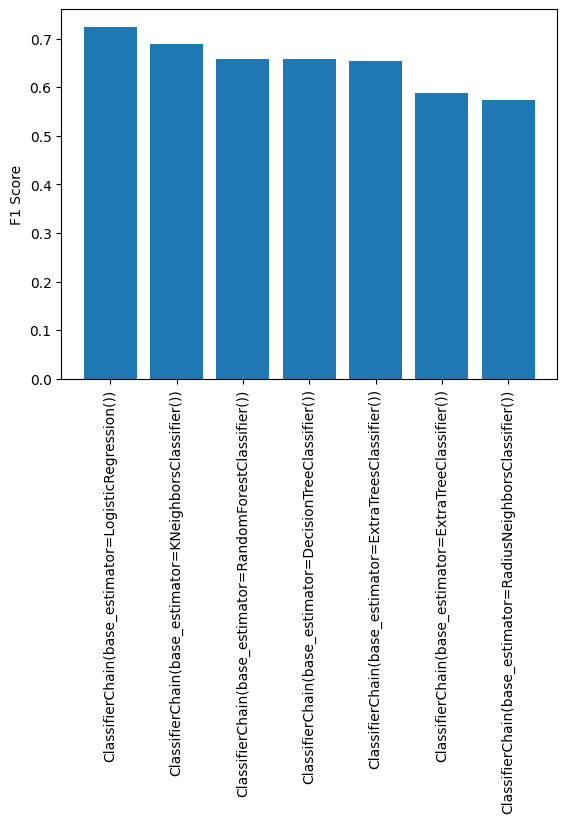

In [99]:
results["param_clf_str"] = results["param_clf"].astype(str)
idx = results.groupby("param_clf_str")["mean_test_score"].idxmax()
max_results = results.loc[idx, ["param_clf_str","mean_test_score", "rank_test_score", "params"]].sort_values("mean_test_score", ascending=False)

plt.bar(max_results["param_clf_str"], max_results["mean_test_score"])
plt.ylabel("F1 Score")
plt.xticks(rotation=90)
plt.show()

In [100]:
score = clf.score(x_test, y_test)
print(clf.best_estimator_)
print("Best model's score on the test dataset: ", score)

Pipeline(steps=[('clf',
                 ClassifierChain(base_estimator=LogisticRegression(C=7)))])
Best model's score on the test dataset:  0.7166454891994918


<div class="alert alert-info">

## Results and Discussion

</div>

Based on the results of the exploratory data analysis, the dataset is imbalanced in terms of job types and categories. The distribution of job types is skewed towards "Permanent" roles, while certain job categories are more prevalent than others. This imbalance could affect the model's performance, especially for less common job types or categories. The Chi-Square test of independence revealed that the job type and job category labels are independent of each other.

The results of the Singular Vector Decomposition (SVD) showed that the first 1768 components explain 85% of the variance in the dataset. This reduction in dimensionality can help improve the model's performance by capturing the most important features while reducing noise.

The dataset is trained in two phases: one where the labels are treated independently and another where they are treated as dependent. Results show that the `LogisticRegression` model performed best in both scenarios, with the highest average F1 score of ~71%. Other tree-related models also performed well.  

The fact that classifier chains (which model dependencies between labels) didn't significantly outperform the multioutput classifier (which assumes independence) suggests that the ***relationships between the labels might be weak or not strongly predictive***.  This is consistent with the results of the Chi-Square test of independence, which indicated that the two labels are not significantly associated with each other.

In this case, the added complexity of modeling dependencies might not be necessary. Simpler models like the multioutput classifier could be sufficient for this type of dataset for interpretability purposes. 

<div class="alert alert-info">

## Conclusion

***A Multi-Output Approach to Improving Job Listing Classification***

</div>

This study aimed to predict the industry and employment status of job listings based solely on their textual descriptions. To address this multi-output classification problem, we employed two primary models: MultiOutput Classification and ClassificationChain. A key consideration in multi-output classification is the potential dependence between labels. By capturing these relationships, models can achieve improved accuracy and generalization, particularly in applications like job matching and recommendations. 

**Model Performance and Insights**
- **Independence Assumption**: Training the MultiOutput Logistic Regression model under the assumption of label independence yielded strong performance, outperforming K-Nearest Neighbors and Decision Trees in terms of F1-score. 

- **Dependence Assumption**: The ClassifierChain Logistic Regression model, trained assuming label dependence, achieved the highest overall accuracy. 

- **Target Variable Dependence**: While the chi-squared test indicated independence between the target variables, the dominance of the pharmaceutical industry in the dataset might have influenced this result. Further analysis on a more balanced dataset could provide deeper insights into label dependencies. 

- **Computational Efficiency**: Balancing accuracy and computational efficiency is crucial in multi-output models. Techniques like feature selection and dimensionality reduction can help optimize performance. 

- **Multi-Output vs. Single-Output**: Comparing multi-output and single-label models resulted in no significant difference as demonstrated by the KNeighborsClassifier. This shows that `MultiOutputClassifier()` operates similarly to training individual models for each label and then combining their outputs. 

While the limitations of the dataset may not have fully captured the potential advantages of multi-output algorithms, their benefits are evident in scenarios involving interdependent labels, optimal hyperparameter tuning of multiple target variables, and the desire for a unified framework for training and deploying models. 

This study successfully applied MultiOutput Logistic Regression and ClassifierChain Logistic Regression to predict multiple target variables from textual job descriptions. By leveraging the strengths of this approach and exploring future advancements, we can further enhance the accuracy and efficiency of job classification models, benefiting both job seekers and employers. 

## References:

1.  phiyodr. (2024). multilabel-oversampling [Computer software]. GitHub. Retrieved November 26, 2024, from https://github.com/phiyodr/multilabel-oversampling
2.  [Read, J., Pfahringer, B., Holmes, G., & Frank, E. (2020). Classifier chains: A review and perspectives. arXiv.](https://arxiv.org/pdf/1912.13405)
3.  Scikit-learn developers. (2024). 1.12. Multiclass and multioutput algorithms — scikit-learn 1.5.2 documentation. Retrieved November 25, 2024, from https://scikit-learn.org/1.5/modules/multiclass.html
